### 0 - Preparação do ambiente

#### 0.1 - Instalação de bibliotecas utilizadas ao longo do código

In [0]:
%pip install pandas --quiet
%pip install matplotlib --quiet
%pip install seaborn --quiet
%pip install tabulate --quiet
%pip install numpy --quiet

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


#### 0.2 - Importação dos pacotes

In [0]:
#importação de pacotes

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tabulate import tabulate
from pyspark.sql import SparkSession
import numpy as np

#### 0.3 - Criação dos schemas de dados na arquitetura Medallion

In [0]:
%sql

CREATE DATABASE bronze;
CREATE DATABASE silver;
CREATE DATABASE gold;

#### 0.4 - Funções utilizadas ao longo do notebook

In [0]:
def tipo_coluna(coluna):
    if pd.api.types.is_numeric_dtype(fato[coluna]):
        return "Numérica"
    else:
        return "Categórica"
    
def categorizar_quartis(df_input, coluna):

    df = df_input.copy()

    quartil_1 = df[coluna].quantile(0.25)
    quartil_2 = df[coluna].quantile(0.5)
    quartil_3 = df[coluna].quantile(0.75)

    bins = [
        df[coluna].min(),
        quartil_1,
        quartil_2,
        quartil_3,
        df[coluna].max(),
    ]

    labels = [
        "1º quartil",
        "2º quartil",
        "3º quartil",
        "4º quartil",
    ]

    categorias = pd.cut(
        df[coluna],
        bins=bins,
        labels=labels,
        include_lowest=True,
    )

    categorias = categorias.cat.add_categories("Não informado")

    df["Categoria"] = categorias.fillna("Não informado").astype(str)

    return df

def converter_numerico(df_input, coluna):
    df = df_input.copy()

    df[coluna] = pd.to_numeric(
        df[coluna], errors="coerce"
    )

    return df

def padronizar_cidades(df, coluna, lista_strings):
    df = df.copy()
    df[coluna] = df[coluna].replace(lista_strings, "", regex=True)
    df[coluna] = df[coluna].str.strip()
    return df

def categorizar(valor):
    if valor == "unarmed":
        return "Desarmado"
    elif "unknown" in str(valor) or valor == "undetermined":
        return "Desconhecido"
    else:
        return "Armado"

### **1 - ETL para criação das tabelas de nível bronze**

##### **1.1 - Extração inicial das bases**


Para o desenvolvimento deste trabalho, adotou-se o modelo **Estrela** na distribuição das tabelas. As bases utilizadas e seus respectivos descritivos estão listados a seguir:

**Tabelas fato**

- **PoliceKillingsUS.csv**: Apresenta dados sobre homicídios praticados por policiais nos Estados Unidos em um determinado período.

**Tabelas dimensão**

- **MedianHouseholdIncome2015.csv**: Contém informações sobre a mediana da renda domiciliar por cidade;

- **PercentagePeopleBelowPovertyLevel.csv**: Indica o percentual da população que vive abaixo da linha da pobreza, por cidade;

- **PercentOver25CompletedHighSchool.csv**: Apresenta o percentual de pessoas acima de 25 anos que concluíram o ensino médio;

- **ShareRaceByCity.csv**: Mostra a distribuição racial das cidades americanas;

- **sub-est2019_all.csv**: Traz informações sobre a população das cidades dos Estados Unidos;

- **fips_codes**: Fornece a correspondência entre os códigos dos estados americanos.

Maiores detalhes sobre a origem dos dados podem ser encontrados no arquivo **README**.

In [0]:
#Tabela fato

fato = pd.read_csv(
    "https://raw.githubusercontent.com/rafaelhasslocher/analise-violencia-policial/main/data/PoliceKillingsUS.csv",
    encoding="latin1",
)

#Tabela dimensão 1 - Renda Mediana por Cidade

dimensao_renda_mediana = pd.read_csv(
    "https://raw.githubusercontent.com/rafaelhasslocher/analise-violencia-policial/main/data/MedianHouseholdIncome2015.csv",
    encoding="latin1",
)

#Tabela dimensão 2 - Percentual de pessoas abaixo da linha da pobreza por cidade

dimensao_linha_pobreza = pd.read_csv(
    "https://raw.githubusercontent.com/rafaelhasslocher/analise-violencia-policial/main/data/PercentagePeopleBelowPovertyLevel.csv",
    encoding="latin1",
)

#Tabela dimensão 3 - Percentual de pessoas acima de 25 anos que completaram o ensino médio por cidade

dimensao_escolaridade = pd.read_csv(
    "https://raw.githubusercontent.com/rafaelhasslocher/analise-violencia-policial/main/data/PercentOver25CompletedHighSchool.csv",
    encoding="latin1",
)

#Tabela dimensão 4 - Distribuição percentual de raças por cidade

dimensao_percentual_racas = pd.read_csv(
    "https://raw.githubusercontent.com/rafaelhasslocher/analise-violencia-policial/main/data/ShareRaceByCity.csv",
    encoding="latin1",
)

#Tabela dimensão 5 - População por cidade americana

dimensao_populacao = pd.read_csv(
    "https://raw.githubusercontent.com/rafaelhasslocher/analise-violencia-policial/main/data/sub-est2019_all.csv",
    encoding="latin1",
)

#Tabela dimensão 6 - Identificador dos códigos dos estados americanos

codigos_cidades = pd.read_csv(
    "https://raw.githubusercontent.com/rafaelhasslocher/analise-violencia-policial/main/data/fips_codes.csv",
    encoding="latin1",
)

No código acima, performamos a leitura das tabelas utilizando o pacote `pandas`. No entanto, para a utilização do Spark, existem maiores restrições quanto à nomenclatura das tabelas, de modo que será necessário alterar o nome das colunas para retirar espaços.

##### **1.2 - Realizar as transformações necessárias na tabela para a subida no schema bronze**

In [0]:
fato_spark = spark.createDataFrame(fato)

dimensao_renda_mediana.columns = [
    col.strip().replace(" ", "_").lower()
    for col in dimensao_renda_mediana.columns
]

dimensao_renda_mediana_spark = spark.createDataFrame(dimensao_renda_mediana)   

dimensao_linha_pobreza.columns = [
    col.strip().replace(" ", "_").lower()
    for col in dimensao_linha_pobreza.columns
]

dimensao_linha_pobreza_spark = spark.createDataFrame(dimensao_linha_pobreza)

dimensao_escolaridade.columns = [
    col.strip().replace(" ", "_").lower()
    for col in dimensao_escolaridade.columns
]

dimensao_escolaridade_spark = spark.createDataFrame(dimensao_escolaridade)

dimensao_percentual_racas.columns = [
    col.strip().replace(" ", "_").lower()
    for col in dimensao_percentual_racas.columns
]

dimensao_percentual_racas_spark = spark.createDataFrame(dimensao_percentual_racas)

dimensao_populacao.columns = [
    col.strip().replace(" ", "_").lower()
    for col in dimensao_populacao.columns
]

dimensao_populacao_spark = spark.createDataFrame(dimensao_populacao)

codigos_cidades.columns = [
    col.strip().replace(" ", "_").lower()
    for col in codigos_cidades.columns
]

codigos_cidades_spark = spark.createDataFrame(codigos_cidades)

##### **1.3 - Carregar as tabelas trabalhadas no schema bronze**

In [0]:
fato_spark.write.mode("overwrite").saveAsTable("bronze.fato") 

dimensao_renda_mediana_spark.write.mode("overwrite").saveAsTable("bronze.dimensao_renda_mediana")
    
dimensao_linha_pobreza_spark.write.mode("overwrite").saveAsTable("bronze.dimensao_linha_pobreza")

dimensao_escolaridade_spark.write.mode("overwrite").saveAsTable("bronze.dimensao_escolaridade")

dimensao_percentual_racas_spark.write.mode("overwrite").saveAsTable("bronze.dimensao_percentual_racas")

dimensao_populacao_spark.write.mode("overwrite").saveAsTable("bronze.dimensao_populacao")

codigos_cidades_spark.write.mode("overwrite").saveAsTable("bronze.codigos_cidades")

### **2 - ETL para criação das tabelas nível silver**

#### **2.1 - Tabela Fato - Homicídios policiais registrados nos Estados Unidos**

##### **2.1.1 - Extrair a tabela do schema bronze e performar a análise exploratória**

In [0]:
bronze_fato = spark.table("bronze.fato").toPandas()

info = [
    [coluna, bronze_fato[coluna].dtype, tipo_coluna(coluna), bronze_fato[coluna].isnull().sum(), bronze_fato[coluna].nunique()]
    for coluna in bronze_fato.columns
]

headers = ["Coluna", "Tipo de Dado", "Categoria", "Valores Nulos", "Valores Únicos"]
tabela = tabulate(info, headers=headers, tablefmt="fancy_grid", colalign=("center", "center", "center", "center", "center"))

print("\nAnálise da tabela fato\n")
print(tabela)


Análise da tabela fato

╒═════════════════════════╤════════════════╤═════════════╤═════════════════╤══════════════════╕
│         Coluna          │  Tipo de Dado  │  Categoria  │  Valores Nulos  │  Valores Únicos  │
╞═════════════════════════╪════════════════╪═════════════╪═════════════════╪══════════════════╡
│           id            │     int64      │  Numérica   │        0        │       2535       │
├─────────────────────────┼────────────────┼─────────────┼─────────────────┼──────────────────┤
│          name           │     object     │ Categórica  │        0        │       2481       │
├─────────────────────────┼────────────────┼─────────────┼─────────────────┼──────────────────┤
│          date           │     object     │ Categórica  │        0        │       879        │
├─────────────────────────┼────────────────┼─────────────┼─────────────────┼──────────────────┤
│     manner_of_death     │     object     │ Categórica  │        0        │        2         │
├──────────────

Conforme pode ser verificado acima, a tabela fato é constituída por uma variável de "id", uma variável numérica (idade) e 12 variáveis categóricas. No entanto, chama a atenção a coluna "date", cuja expectativa seria de um formato de data.

Verificamos, ainda, que três colunas apresentam contagem de valores nulos.

A seguir, performamos uma análise sobre a coluna de nome, de modo a verificar a possibilidade de registros duplicados e/ou inconsistentes

In [0]:
contagem_nomes = bronze_fato["name"].count()

print(f"Total de óbitos presentes na base:  {contagem_nomes}")

groupby_nomes = bronze_fato.groupby("name")["id"].count().reset_index(name="Quantidade").sort_values(by="Quantidade", ascending=False)

groupby_nomes = groupby_nomes[groupby_nomes["Quantidade"] > 1].rename(columns={"name": "Nome"})

groupby_nomes = tabulate(groupby_nomes, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center"))

print(f"\nNomes repetidos na base:\n\n{groupby_nomes}")


Total de óbitos presentes na base:  2535

Nomes repetidos na base:

╒══════════════════════════╤══════════════╕
│           Nome           │  Quantidade  │
╞══════════════════════════╪══════════════╡
│          TK TK           │      49      │
├──────────────────────────┼──────────────┤
│ Daquan Antonio Westbrook │      2       │
├──────────────────────────┼──────────────┤
│       Eric Harris        │      2       │
├──────────────────────────┼──────────────┤
│      Brandon Jones       │      2       │
├──────────────────────────┼──────────────┤
│          TK Tk           │      2       │
├──────────────────────────┼──────────────┤
│     Michael Johnson      │      2       │
├──────────────────────────┼──────────────┤
│      Michael Brown       │      2       │
╘══════════════════════════╧══════════════╛


Conforme pode ser verificado acima, alguns dos nomes aparecem duplicidade na base. Como não há, nos dados, um identificador específico de cada pessoa (por exemplo, CPF), é possível que os óbitos de fato tenham ocorrido entre homônimos. 

No entanto, chama a atenção a repetição de valores de nome "TK TK" ou "TK Tk", o que parece ser algum tipo de inconsistência no registro das informações. Nesse sentido, é de interesse investigar se há algum tipo de concentração por cidade, de modo a verificar a possibilidade de manipulação dos dados.

In [0]:
repetidos_cidades = (
    bronze_fato[bronze_fato["name"].isin(["TK TK", "TK tk"])]
    .groupby("city")["id"]
    .count()
    .reset_index(name="Quantidade")
    .sort_values(by="Quantidade", ascending=False)
    .rename(columns={"city": "Cidade"})
)

repetidos_cidades = repetidos_cidades[repetidos_cidades["Quantidade"] > 1]

repetidos_cidades = tabulate(repetidos_cidades, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center"))

print(f"\nCidades associadas a nomes aparentemente inconsistentes:\n\n{repetidos_cidades}")


Cidades associadas a nomes aparentemente inconsistentes:

╒═════════════╤══════════════╕
│   Cidade    │  Quantidade  │
╞═════════════╪══════════════╡
│  Las Vegas  │      2       │
├─────────────┼──────────────┤
│   Phoenix   │      2       │
├─────────────┼──────────────┤
│ Los Angeles │      2       │
├─────────────┼──────────────┤
│  Arlington  │      2       │
╘═════════════╧══════════════╛


Conforme pode ser verificado acima, não foi identificada concentração que possa distorcer significativamente as conclusões desse trabalho.

In [0]:
colunas = ["manner_of_death", "gender", "race", "signs_of_mental_illness", "threat_level", "flee", "body_camera", "armed"]

for coluna in colunas:
    groupby = bronze_fato.groupby(coluna)["id"].count().reset_index(name="Quantidade").sort_values(by="Quantidade", ascending=False)
    groupby = tabulate(groupby, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center"))
    print(f"\nValores Únicos da coluna '{coluna}':\n\n{groupby}")


Valores Únicos da coluna 'manner_of_death':

╒═══════════════════╤══════════════╕
│  manner_of_death  │  Quantidade  │
╞═══════════════════╪══════════════╡
│       shot        │     2363     │
├───────────────────┼──────────────┤
│ shot and Tasered  │     172      │
╘═══════════════════╧══════════════╛

Valores Únicos da coluna 'gender':

╒══════════╤══════════════╕
│  gender  │  Quantidade  │
╞══════════╪══════════════╡
│    M     │     2428     │
├──────────┼──────────────┤
│    F     │     107      │
╘══════════╧══════════════╛

Valores Únicos da coluna 'race':

╒════════╤══════════════╕
│  race  │  Quantidade  │
╞════════╪══════════════╡
│   W    │     1201     │
├────────┼──────────────┤
│   B    │     618      │
├────────┼──────────────┤
│   H    │     423      │
├────────┼──────────────┤
│   A    │      39      │
├────────┼──────────────┤
│   N    │      31      │
├────────┼──────────────┤
│   O    │      28      │
╘════════╧══════════════╛

Valores Únicos da coluna 'signs_of_m

Acima, foram geradas tabelas de frequência referentes às colunas categóricas da tabela fato, sobre as quais se incluem os seguintes comentários:

- **Coluna "manner_of_death":** Verificamos os dados fortemente concentrados nas mortes a tiro. A princípio, não identificamos relevância dessa variável para as respostas colocadas no objetivo do trabalho, de modo que ela será desconsiderada no nível silver;

- **Coluna "gender":** Novamente, há uma forte concentração em uma das categorias e sem relevância aparente para o objetivo. A coluna será desconsiderada no nível silver;

- **Coluna "race":** As categorias são identificadas somente pelas suas iniciais, de modo que faremos a transformação para facilitar a visualização nas tabelas e gráficos subsequentes. Embora a maioria dos óbitos seja de brancos (categoria "W"), chama a atenção a quantidade de homicídios de pessoas pretas (categoria "B") e de etnia hispânica (categoria "H") frente ao perfil demográfico dos Estados Unidos, com esmagadora maioria da população identificada como branca;

- Coluna "signs_of_mental_illness":** Na análise dessa tabela, destaca-se a quantidade de homicídios sobre pessoas com doenças mentais frente ao total. No entanto, entendemos que a coluna não seria relevante para o objetivo do trabalho, de modo que ela também será desconsiderada;

- **Coluna "threat_level":** Conforme esperado, a grande maioria dos homicídios são identificados sendo contra pessoas que ofereciam algum tipo de perigo ao oficial. No entanto, é relevante pontuar que se trata de critério subjetivo, estando aberto à interpretação dos presentes na cena, de modo que preferimos desconsiderar essa variável;

- **Coluna "flee":** Dado o comportamento da variável "threat_level", o comportamento das categorias não causa surpresa. A coluna também será desconsiderada no nível silver;

- **Coluna "body_camera":** Quase todos os registros da base identificam o oficial sem câmera corporal, o que também compõe o comportamento esperado. A coluna será desconsiderada no nível silver;

<b><span style="color:red;">INCLUIR COMENTÁRIO PARA COLUNA ARMED</span></b>


##### 2.1.2 - Realizar as transformações necessárias na tabela para a subida no schema silver

In [0]:
silver_fato = bronze_fato.copy()

silver_fato["date"] = pd.to_datetime(silver_fato['date'], format="%d/%m/%y")

print(f"Menor data observada na base: {fato['date'].min()}")

print(f"Maior data observada na base: {fato['date'].max()}")

silver_fato["mes"] = silver_fato['date'].dt.month
silver_fato["ano"] = silver_fato['date'].dt.year
    
silver_fato["categoria_armado"] = silver_fato["armed"].apply(categorizar)

silver_fato = padronizar_cidades(silver_fato, "city", ["city", "CDP", "town"])

silver_fato = silver_fato.dropna(subset=["race"])

silver_fato["raca"] = (
    silver_fato["race"]
    .map(
        {
            "A": "Asiático",
            "W": "Branco",
            "H": "Hispânico",
            "B": "Preto",
            "O": "Outros",
            "N": "Indígena",
        }
    )
)

silver_fato["cidade"] = silver_fato["city"] + ", " + silver_fato["state"]

silver_fato["camera_corporal"] = silver_fato["body_camera"].map(
    {True: "Sim", False: "Não"}
)

silver_fato["nivel_ameaca"] = silver_fato["threat_level"].map(
    {"attack": "Ataque", "undetermined": "Indeterminado", "other": "Outros"}
)

silver_fato["genero"] = silver_fato["gender"].map({"M": "Masculino", "F": "Feminino"})

silver_fato = silver_fato.drop(
    columns={
        "name",
        "date",
        "manner_of_death",
        "age",
        "armed",
        "gender",
        "race",
        "city",
        "state",
        "signs_of_mental_illness",
        "threat_level",
        "flee",
        "body_camera",
    }
)

silver_fato_spark = spark.createDataFrame(silver_fato)

##### **2.1.3 - Carregar a tabela trabalhada no schema silver**

In [0]:
silver_fato_spark.write.mode("overwrite").saveAsTable("silver.fato")

#### **2.2 - Tabela Dimensão 1 - Renda Mediana por Cidade**

##### **2.2.1 - Extrair a tabela do schema bronze e performar a análise exploratória**

In [0]:
dimensao_renda_mediana = spark.table("bronze.dimensao_renda_mediana").toPandas()

silver_dimensao_renda_mediana = dimensao_renda_mediana.copy()

info = pd.DataFrame({
    "Coluna": silver_dimensao_renda_mediana.columns,
    "Tipo": silver_dimensao_renda_mediana.dtypes.astype(str),
    "Valores Nulos": silver_dimensao_renda_mediana.isnull().sum(),
    "Valores Únicos": silver_dimensao_renda_mediana.nunique()
})

tabela = tabulate(info, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print(f"\nInformações da tabela 'Renda Mediana das Cidades Americanas':\n\n{tabela}")



Informações da tabela 'Renda Mediana das Cidades Americanas':

╒═════════════════╤════════╤═════════════════╤══════════════════╕
│     Coluna      │  Tipo  │  Valores Nulos  │  Valores Únicos  │
╞═════════════════╪════════╪═════════════════╪══════════════════╡
│ geographic_area │ object │        0        │        51        │
├─────────────────┼────────┼─────────────────┼──────────────────┤
│      city       │ object │        0        │      24249       │
├─────────────────┼────────┼─────────────────┼──────────────────┤
│  median_income  │ object │       51        │      14592       │
╘═════════════════╧════════╧═════════════════╧══════════════════╛


##### **2.2.2 - Realizar as transformações necessárias na tabela para a subida no schema silver**

In [0]:
#renomear colunas para facilitar a referência

silver_dimensao_renda_mediana = silver_dimensao_renda_mediana.rename(
    columns={"median_income": "renda_mediana"}
)

#padronização do nome das cidades

silver_dimensao_renda_mediana = padronizar_cidades(
    silver_dimensao_renda_mediana, "city", ["city", "CDP", "town"]
)

#converter a coluna de interesse para o formato numérico

silver_dimensao_renda_mediana = converter_numerico(
    silver_dimensao_renda_mediana, "renda_mediana"
)

#concatenação dos nomes de cidades e estados

silver_dimensao_renda_mediana["cidade"] = (
    silver_dimensao_renda_mediana["city"]
    + ", "
    + silver_dimensao_renda_mediana["geographic_area"]
)

#substituir valores não preenchidos pela média dos respectivos estados

silver_dimensao_renda_mediana["renda_mediana"] = silver_dimensao_renda_mediana[
    "renda_mediana"
].fillna(
    silver_dimensao_renda_mediana.groupby("geographic_area")["renda_mediana"].transform(
        "mean"
    )
)

#verificar se há registros duplicados

silver_dimensao_renda_mediana[silver_dimensao_renda_mediana["cidade"].duplicated()]

,geographic_area,city,renda_mediana,cidade
392,DE,Arden village,61071.0,"Arden village, DE"
877,FL,Lake Butler,27763.0,"Lake Butler, FL"
1122,FL,Plantation,60819.0,"Plantation, FL"
1776,GA,Mountain Park,70814.0,"Mountain Park, GA"
2536,IL,Browns village,45625.0,"Browns village, IL"
...,...,...,...,...
26009,IN,Highland,66188.0,"Highland, IN"
28273,KY,Fairview,56406.0,"Fairview, KY"
28597,KY,Union,24150.0,"Union, KY"
28621,KY,Westwood,81875.0,"Westwood, KY"


In [0]:
##agrupar resultados duplicados pela média entre eles

silver_dimensao_renda_mediana = silver_dimensao_renda_mediana.groupby(["cidade"], dropna=False)["renda_mediana"].mean(numeric_only=True).reset_index()

#separar os dados em quartis

silver_dimensao_renda_mediana = categorizar_quartis(silver_dimensao_renda_mediana, "renda_mediana")

#tabela final

silver_dimensao_renda_mediana = silver_dimensao_renda_mediana.rename(columns={"Categoria": "quartil_renda_mediana"})

silver_dimensao_renda_mediana_spark = spark.createDataFrame(silver_dimensao_renda_mediana)

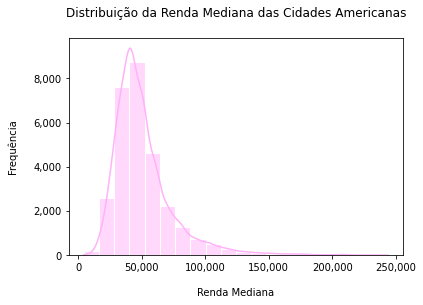

In [0]:
#verificar graficamente a distribuição de renda mediana

grafico = sns.histplot(
    silver_dimensao_renda_mediana["renda_mediana"],
    bins=20,
    color="#ffb2f9",
    edgecolor="#FFFFFF",
    kde=True,
)

grafico.set(
    xlabel="\nRenda Mediana", ylabel="Frequência\n", title="Distribuição da Renda Mediana das Cidades Americanas\n"
)

grafico.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
grafico.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.show()


##### **2.2.3 - Carregar a tabela trabalhada no schema silver**

In [0]:
silver_dimensao_renda_mediana_spark.write.mode("overwrite").saveAsTable("silver.dimensao_renda_mediana")

#### **2.3 - Tabela Dimensão 2 - Percentual de pessoas abaixo da linha da pobreza por cidade**

##### **2.3.1 - Extrair a tabela do schema bronze e performar a análise exploratória**

In [0]:
dimensao_linha_pobreza = spark.table("bronze.dimensao_linha_pobreza").toPandas()

silver_dimensao_linha_pobreza = dimensao_linha_pobreza.copy()

info = pd.DataFrame({
    "Coluna": silver_dimensao_linha_pobreza.columns,
    "Tipo": silver_dimensao_linha_pobreza.dtypes.astype(str),
    "Valores Nulos": silver_dimensao_linha_pobreza.isnull().sum(),
    "Valores Únicos": silver_dimensao_linha_pobreza.nunique()
})

tabela = tabulate(info, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print(f"\nInformações da tabela 'Percentual da População Abaixo da Linha da Pobreza':\n\n{tabela}")


Informações da tabela 'Percentual da População Abaixo da Linha da Pobreza':

╒═════════════════╤════════╤═════════════════╤══════════════════╕
│     Coluna      │  Tipo  │  Valores Nulos  │  Valores Únicos  │
╞═════════════════╪════════╪═════════════════╪══════════════════╡
│ geographic_area │ object │        0        │        51        │
├─────────────────┼────────┼─────────────────┼──────────────────┤
│      city       │ object │        0        │      24255       │
├─────────────────┼────────┼─────────────────┼──────────────────┤
│  poverty_rate   │ object │        0        │       771        │
╘═════════════════╧════════╧═════════════════╧══════════════════╛


##### **2.3.2 - Realizar as transformações necessárias na tabela para a subida no schema silver**

In [0]:
#renomear colunas para facilitar a referência

silver_dimensao_linha_pobreza = silver_dimensao_linha_pobreza.rename(
    columns={"poverty_rate": "indice_pobreza"}
)

#padronização do nome das cidades

silver_dimensao_linha_pobreza = padronizar_cidades(
    silver_dimensao_linha_pobreza, "city", ["city", "CDP", "town"]
)

#converter a coluna de interesse para o formato numérico

silver_dimensao_linha_pobreza = converter_numerico(
    silver_dimensao_linha_pobreza, "indice_pobreza"
)

#concatenação dos nomes de cidades e estados

silver_dimensao_linha_pobreza["cidade"] = (
    silver_dimensao_linha_pobreza["city"]
    + ", "
    + silver_dimensao_linha_pobreza["geographic_area"]
)

#verificar se há registros duplicados

silver_dimensao_linha_pobreza[silver_dimensao_linha_pobreza["cidade"].duplicated()]

,geographic_area,city,indice_pobreza,cidade
544,AL,Union,48.4,"Union, AL"
1032,AZ,Cottonwood,19.9,"Cottonwood, AZ"
1253,AZ,St. Johns,46.4,"St. Johns, AZ"
1388,AZ,Young,22.5,"Young, AZ"
1726,AR,Midway,10.2,"Midway, AR"
...,...,...,...,...
26015,IN,Highland,2.2,"Highland, IN"
28281,KY,Fairview,6.6,"Fairview, KY"
28606,KY,Union,37.0,"Union, KY"
28630,KY,Westwood,5.9,"Westwood, KY"


In [0]:
##agrupar resultados duplicados pela média entre eles

silver_dimensao_linha_pobreza = silver_dimensao_linha_pobreza.groupby(["cidade"], dropna=False)["indice_pobreza"].mean(numeric_only=True).reset_index()

#separar os dados em quartis

silver_dimensao_linha_pobreza = categorizar_quartis(silver_dimensao_linha_pobreza, "indice_pobreza")

#tabela final

silver_dimensao_linha_pobreza = silver_dimensao_linha_pobreza.rename(columns={"Categoria": "quartil_linha_pobreza"})

silver_dimensao_linha_pobreza_spark = spark.createDataFrame(silver_dimensao_linha_pobreza)

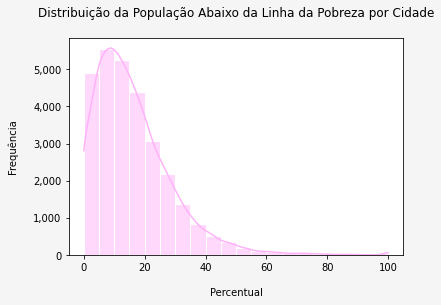

In [0]:
#verificar graficamente a distribuição da população abaixo da linha da pobreza

grafico = sns.histplot(
    silver_dimensao_linha_pobreza["indice_pobreza"],
    bins=20,
    color="#ffb2f9",
    edgecolor="#FFFFFF",
    kde=True,
)

grafico.set(
    xlabel="\nPercentual", ylabel="Frequência\n", title="Distribuição da População Abaixo da Linha da Pobreza por Cidade\n"
)

plt.gcf().set_facecolor("whitesmoke")

grafico.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
grafico.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.show()


##### **2.3.3 - Carregar a tabela trabalhada no schema silver**

In [0]:
silver_dimensao_linha_pobreza_spark.write.mode("overwrite").saveAsTable("silver.dimensao_linha_pobreza")

#### **2.4 - Tabela Dimensão 3 - Percentual de pessoas acima de 25 anos que completaram o ensino médio por cidade**

##### **2.4.1 - Extrair a tabela do schema bronze e performar a análise exploratória**

In [0]:
dimensao_escolaridade = spark.table("bronze.dimensao_escolaridade").toPandas()

silver_dimensao_escolaridade = dimensao_escolaridade.copy()

info = pd.DataFrame({
    "Coluna": silver_dimensao_escolaridade.columns,
    "Tipo": silver_dimensao_escolaridade.dtypes.astype(str),
    "Valores Nulos": silver_dimensao_escolaridade.isnull().sum(),
    "Valores Únicos": silver_dimensao_escolaridade.nunique()
})

tabela = tabulate(info, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print(f"\nInformações da tabela 'População que Completou o Ensino Médio':\n\n{tabela}")


Informações da tabela 'População que Completou o Ensino Médio':

╒══════════════════════╤════════╤═════════════════╤══════════════════╕
│        Coluna        │  Tipo  │  Valores Nulos  │  Valores Únicos  │
╞══════════════════════╪════════╪═════════════════╪══════════════════╡
│   geographic_area    │ object │        0        │        51        │
├──────────────────────┼────────┼─────────────────┼──────────────────┤
│         city         │ object │        0        │      24255       │
├──────────────────────┼────────┼─────────────────┼──────────────────┤
│ percent_completed_hs │ object │        0        │       728        │
╘══════════════════════╧════════╧═════════════════╧══════════════════╛


##### **2.4.2 - Realizar as transformações necessárias na tabela para a subida no schema silver**

In [0]:
#renomear colunas para facilitar a referência

silver_dimensao_escolaridade = silver_dimensao_escolaridade.rename(
    columns={"percent_completed_hs": "percentual_em"}
)

#padronização do nome das cidades

silver_dimensao_escolaridade = padronizar_cidades(
    silver_dimensao_escolaridade, "city", ["city", "CDP", "town"]
)

#converter a coluna de interesse para o formato numérico

silver_dimensao_escolaridade = converter_numerico(
    silver_dimensao_escolaridade, "percentual_em"
)

#concatenação dos nomes de cidades e estados

silver_dimensao_escolaridade["cidade"] = (
    silver_dimensao_escolaridade["city"]
    + ", "
    + silver_dimensao_escolaridade["geographic_area"]
)

#verificar se há registros duplicados

silver_dimensao_escolaridade[silver_dimensao_escolaridade["cidade"].duplicated()]

,geographic_area,city,percentual_em,cidade
544,AL,Union,66.1,"Union, AL"
1032,AZ,Cottonwood,84.9,"Cottonwood, AZ"
1253,AZ,St. Johns,75.3,"St. Johns, AZ"
1388,AZ,Young,82.7,"Young, AZ"
1726,AR,Midway,87.7,"Midway, AR"
...,...,...,...,...
26015,IN,Highland,97.5,"Highland, IN"
28281,KY,Fairview,89.0,"Fairview, KY"
28606,KY,Union,80.3,"Union, KY"
28630,KY,Westwood,98.3,"Westwood, KY"


In [0]:
##agrupar resultados duplicados pela média entre eles

silver_dimensao_escolaridade = silver_dimensao_escolaridade.groupby(["cidade"], dropna=False)["percentual_em"].mean(numeric_only=True).reset_index()

#separar os dados em quartis

silver_dimensao_escolaridade = categorizar_quartis(silver_dimensao_escolaridade, "percentual_em")

#tabela final

silver_dimensao_escolaridade = silver_dimensao_escolaridade.rename(columns={"Categoria": "quartil_percentual_em"})

silver_dimensao_escolaridade_spark = spark.createDataFrame(silver_dimensao_escolaridade)

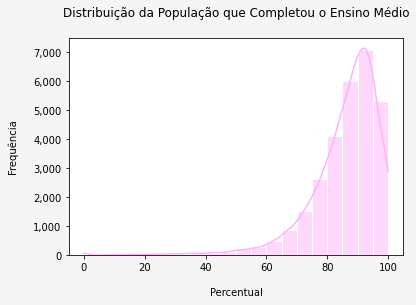

In [0]:
#verificar graficamente a distribuição da população que completou o Ensino Médio

grafico = sns.histplot(
    silver_dimensao_escolaridade["percentual_em"],
    bins=20,
    color="#ffb2f9",
    edgecolor="#FFFFFF",
    kde=True,
)

grafico.set(
    xlabel="\nPercentual", ylabel="Frequência\n", title="Distribuição da População que Completou o Ensino Médio\n"
)

plt.gcf().set_facecolor("whitesmoke")

grafico.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
grafico.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.show()

##### **2.4.3 - Carregar a tabela trabalhada no schema silver**

In [0]:
silver_dimensao_escolaridade_spark.write.mode("overwrite").saveAsTable("silver.dimensao_escolaridade")

#### **2.5 - Tabela Dimensão 4 - Distribuição percentual de raças por cidade**

##### **2.5.1 - Extrair a tabela do schema bronze e performar a análise exploratória**

In [0]:
dimensao_percentual_racas = spark.table("bronze.dimensao_percentual_racas").toPandas()

silver_dimensao_percentual_racas = dimensao_percentual_racas.copy()

info = pd.DataFrame({
    "Coluna": silver_dimensao_percentual_racas.columns,
    "Tipo": silver_dimensao_percentual_racas.dtypes.astype(str),
    "Valores Nulos": silver_dimensao_percentual_racas.isnull().sum(),
    "Valores Únicos": silver_dimensao_percentual_racas.nunique()
})

tabela = tabulate(info, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print(f"\nInformações da tabela 'Distribuição de Raças das Cidades Americanas':\n\n{tabela}")


Informações da tabela 'Distribuição de Raças das Cidades Americanas':

╒═══════════════════════╤════════╤═════════════════╤══════════════════╕
│        Coluna         │  Tipo  │  Valores Nulos  │  Valores Únicos  │
╞═══════════════════════╪════════╪═════════════════╪══════════════════╡
│    geographic_area    │ object │        0        │        51        │
├───────────────────────┼────────┼─────────────────┼──────────────────┤
│         city          │ object │        0        │      24219       │
├───────────────────────┼────────┼─────────────────┼──────────────────┤
│      share_white      │ object │        0        │       997        │
├───────────────────────┼────────┼─────────────────┼──────────────────┤
│      share_black      │ object │        0        │       926        │
├───────────────────────┼────────┼─────────────────┼──────────────────┤
│ share_native_american │ object │        0        │       628        │
├───────────────────────┼────────┼─────────────────┼────────────

##### **2.5.2 - Realizar as transformações necessárias na tabela para a subida no schema silver**

In [0]:
# renomear colunas para facilitar a referência

silver_dimensao_percentual_racas = silver_dimensao_percentual_racas.rename(
    columns={
        "share_white": "percentual_brancos",
        "share_black": "percentual_pretos",
        "share_native_american": "percentual_indigenas",
        "share_asian": "percentual_asiaticos",
        "share_hispanic": "percentual_hispanicos",
    }
)

# padronização do nome das cidades

silver_dimensao_percentual_racas = padronizar_cidades(silver_dimensao_percentual_racas, "city", ["city", "CDP", "town"])

# converter a coluna de interesse para o formato numérico

colunas = silver_dimensao_percentual_racas.columns.drop(["geographic_area", "city"])

for coluna in colunas:
    silver_dimensao_percentual_racas = converter_numerico(
        silver_dimensao_percentual_racas, coluna
    )

# concatenação dos nomes de cidades e estados

silver_dimensao_percentual_racas["cidade"] = (
    silver_dimensao_percentual_racas["city"]
    + ", "
    + silver_dimensao_percentual_racas["geographic_area"]
)

# verificar se há registros duplicados

silver_dimensao_percentual_racas[silver_dimensao_percentual_racas["cidade"].duplicated()]

,geographic_area,city,percentual_brancos,percentual_pretos,percentual_indigenas,percentual_asiaticos,percentual_hispanicos,cidade
537,AL,Union,9.1,90.6,0.0,0.0,0.5,"Union, AL"
1025,AZ,Cottonwood,83.6,0.8,1.8,0.9,22.8,"Cottonwood, AZ"
1246,AZ,St. Johns,2.9,0.2,95.0,0.0,4.0,"St. Johns, AZ"
1381,AZ,Young,73.3,4.3,1.4,2.8,33.0,"Young, AZ"
1720,AR,Midway,97.9,0.0,0.3,0.8,0.8,"Midway, AR"
...,...,...,...,...,...,...,...,...
25969,IN,Highland,96.1,1.3,0.0,1.2,0.8,"Highland, IN"
28228,KY,Fairview,100.0,0.0,0.0,0.0,0.0,"Fairview, KY"
28548,KY,Union,91.2,5.5,0.5,0.1,1.3,"Union, KY"
28571,KY,Westwood,88.8,5.5,0.2,2.2,2.8,"Westwood, KY"


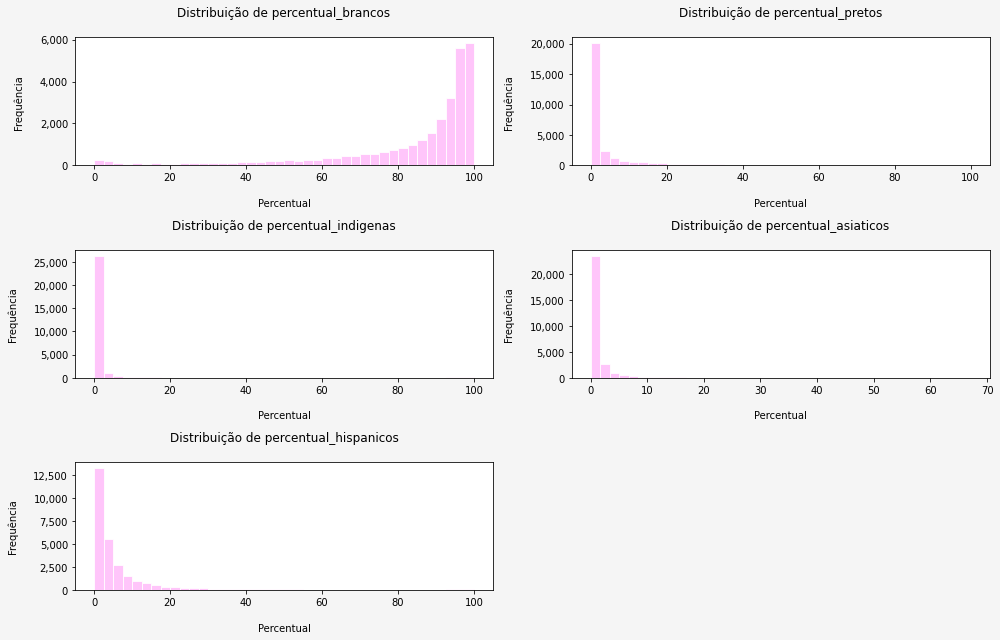

In [0]:
#agrupar resultados duplicados pela média entre eles

silver_dimensao_percentual_racas = silver_dimensao_percentual_racas.groupby(["cidade"], dropna=False)[colunas].mean(numeric_only=True).reset_index()

silver_dimensao_percentual_racas_spark = spark.createDataFrame(silver_dimensao_percentual_racas)

#verificar graficamente a distribuição da população por raças

num_rows = (len(colunas) // 2) + (len(colunas) % 2)
figura, eixos = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, num_rows * 3))
eixos = eixos.flatten()

for i, coluna in enumerate(colunas):
    sns.histplot(silver_dimensao_percentual_racas[coluna], bins=40, ax=eixos[i], color="#ffb2f9", edgecolor="#FFFFFF", kde=True)
    eixos[i].set_title(f"Distribuição de {coluna}\n")
    eixos[i].set_xlabel("\nPercentual")
    eixos[i].set_ylabel("Frequência\n")
    eixos[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
    eixos[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

for j in range(i + 1, len(eixos)):
    eixos[j].set_visible(False)

figura.set_facecolor("whitesmoke")
plt.tight_layout()
plt.show()

##### **2.5.3 - Carregar a tabela trabalhada no schema silver**

In [0]:
silver_dimensao_percentual_racas_spark.write.mode("overwrite").saveAsTable("silver.dimensao_percentual_racas")

#### **2.6 - Tabela Dimensão 5 - População por cidade americana**

##### **2.6.1 - Extrair as tabelas do schema bronze**

In [0]:
codigos_cidades = spark.table("bronze.codigos_cidades").toPandas()

dimensao_populacao = spark.table("bronze.dimensao_populacao").toPandas()

##### **2.6.2 - Realizar as transformações necessárias nas tabelas para a subida no schema silver**

In [0]:
codigos_cidades = codigos_cidades.rename(
    columns={"state": "estado", "statefp": "codigo_estado"}
)

codigos_cidades = codigos_cidades[
    ["estado", "codigo_estado"]
].drop_duplicates(subset=["estado", "codigo_estado"])

silver_dimensao_populacao = dimensao_populacao.copy()

silver_dimensao_populacao = silver_dimensao_populacao.merge(
    codigos_cidades, left_on="state", right_on="codigo_estado", validate="m:1"
)

silver_dimensao_populacao = silver_dimensao_populacao[
    ["estado", "name", "popestimate2016"]
]

silver_dimensao_populacao = padronizar_cidades(
    silver_dimensao_populacao, "name", ["city", "CDP", "town"]
)

silver_dimensao_populacao["cidade"] = silver_dimensao_populacao["name"] + ", " + silver_dimensao_populacao["estado"]

silver_dimensao_populacao = silver_dimensao_populacao.drop_duplicates()

silver_dimensao_populacao = silver_dimensao_populacao.groupby(["cidade"], dropna=False)["popestimate2016"].mean(numeric_only=True).reset_index()

silver_dimensao_populacao = silver_dimensao_populacao.rename(columns={"popestimate2016": "estimativa_populacao"})

silver_dimensao_populacao_spark = spark.createDataFrame(silver_dimensao_populacao)

##### **2.6.3 - Carregar a tabela trabalhada no schema silver**

In [0]:
silver_dimensao_populacao_spark.write.mode("overwrite").saveAsTable("silver.dimensao_populacao")

### **3 - ETL para criação das tabelas nível gold**

#### **3.1 - Tabela Gold 1 - Base de homicídios policiais enriquecidas com dados das cidades de ocorrência**

##### **3.1.1 - Extrair as tabelas do schema silver**

In [0]:
silver_fato = spark.table("silver.fato").toPandas()

silver_dimensao_escolaridade = spark.table("silver.dimensao_escolaridade").toPandas()

silver_dimensao_linha_pobreza = spark.table("silver.dimensao_linha_pobreza").toPandas()

silver_dimensao_percentual_racas = spark.table("silver.dimensao_percentual_racas").toPandas()

silver_dimensao_populacao = spark.table("silver.dimensao_populacao").toPandas()

##### **3.1.2 - Realizar as transformações necessárias na tabela para a subida no schema silver**

In [0]:
fato_homicidios_cidades = (
    silver_fato.merge(
        silver_dimensao_renda_mediana,
        on=["cidade"],
        validate="m:1",
        how="left",
    )
    .merge(
        silver_dimensao_escolaridade,
        on=["cidade"],
        validate="m:1",
        how="left",
    )
    .merge(
        silver_dimensao_linha_pobreza,
        on=["cidade"],
        validate="m:1",
        how="left",
    )
    .merge(
        silver_dimensao_percentual_racas,
        on=["cidade"],
        validate="m:1",
        how="left",
    )
    .merge(
        silver_dimensao_populacao, 
        on=["cidade"], 
        validate="m:1", 
        how="left")
)

fato_homicidios_cidades_spark = spark.createDataFrame(fato_homicidios_cidades)

##### **3.1.3 - Carregar a tabela trabalhada no schema gold**

In [0]:
fato_homicidios_cidades_spark.write.mode("overwrite").saveAsTable("gold.fato_homicidios_cidades")

#### **3.2 - Tabela Gold 2 - Homicídios por Mil Habitantes**

##### **3.2.1 - Extrair a tabela "fato_homicidios_cidades" do schema gold**

In [0]:
fato_homicidios_cidades = spark.table("gold.fato_homicidios_cidades").toPandas()

##### **3.2.2 - Realizar as transformações necessárias na tabela para a subida no schema gold**

In [0]:
fato_homicidios_mil_habitantes = (
    fato_homicidios_cidades.groupby("cidade")["id"]
    .count()
    .reset_index(name="quantidade")
    .sort_values(by="quantidade", ascending=False)
    .merge(
        fato_homicidios_cidades[
            [
                "cidade",
                "estimativa_populacao",
                "percentual_brancos",
                "percentual_pretos",
                "percentual_hispanicos",
                "percentual_asiaticos",
                "percentual_indigenas"
            ]
        ].drop_duplicates(),
        validate="m:1",
        how="left",
        on="cidade",
    )
)

fato_homicidios_mil_habitantes["mortes_mil_habitantes"] = (
    fato_homicidios_mil_habitantes["quantidade"] / fato_homicidios_mil_habitantes["estimativa_populacao"] * 1000
)

fato_homicidios_mil_habitantes_spark = spark.createDataFrame(fato_homicidios_mil_habitantes)

##### **3.2.3 - Carregar a tabela trabalhada no schema gold**

In [0]:
fato_homicidios_mil_habitantes_spark.write.mode("overwrite").saveAsTable("gold.fato_homicidios_mil_habitantes")

### **4 - Criação de gráficos e tabelas de suporte para a análise dos resultados**

#### **4.1 - Contagem de homicídios conforme renda mediana por quartil**

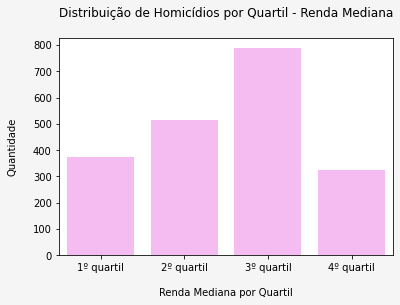

In [0]:
fato_homicidios_cidades = spark.table("gold.fato_homicidios_cidades").toPandas()

groupby = fato_homicidios_cidades.groupby("quartil_renda_mediana")["id"].count().reset_index(name="Quantidade").sort_values(by="quartil_renda_mediana")

grafico = sns.barplot(
    data=groupby,
    x="quartil_renda_mediana",
    y="Quantidade",
    color="#ffb2f9"
)

grafico.figure = plt.gcf()
grafico.figure.set_facecolor("whitesmoke")
grafico.set_xlabel("\nRenda Mediana por Quartil")
grafico.set_ylabel("Quantidade\n")
grafico.set_title("Distribuição de Homicídios por Quartil - Renda Mediana\n")

plt.show()

#### **4.2 - Contagem de homicídios conforme percentual da população abaixo da linha da pobreza por quartil**

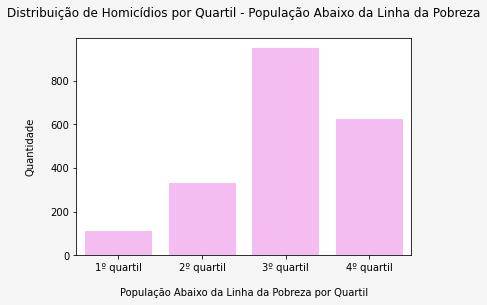

In [0]:
fato_homicidios_cidades = spark.table("gold.fato_homicidios_cidades").toPandas()

groupby = fato_homicidios_cidades.groupby("quartil_linha_pobreza")["id"].count().reset_index(name="Quantidade").sort_values(by="quartil_linha_pobreza")

grafico = sns.barplot(
    data=groupby,
    x="quartil_linha_pobreza",
    y="Quantidade",
    color="#ffb2f9"
)

grafico.figure = plt.gcf()
grafico.figure.set_facecolor("whitesmoke")
grafico.set_xlabel("\nPopulação Abaixo da Linha da Pobreza por Quartil")
grafico.set_ylabel("Quantidade\n")
grafico.set_title("Distribuição de Homicídios por Quartil - População Abaixo da Linha da Pobreza\n")

plt.show()

#### **4.3 - Contagem de homicídios conforme percentual da população acima de 25 anos com Ensino Médio completo**

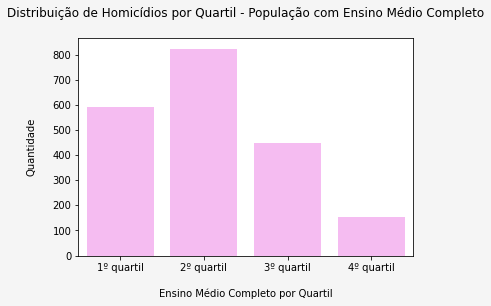

In [0]:
fato_homicidios_cidades = spark.table("gold.fato_homicidios_cidades").toPandas()

groupby = fato_homicidios_cidades.groupby("quartil_percentual_em")["id"].count().reset_index(name="Quantidade").sort_values(by="quartil_percentual_em")

grafico = sns.barplot(
    data=groupby,
    x="quartil_percentual_em",
    y="Quantidade",
    color="#ffb2f9"
)

grafico.figure = plt.gcf()
grafico.figure.set_facecolor("whitesmoke")
grafico.set_xlabel("\nEnsino Médio Completo por Quartil")
grafico.set_ylabel("Quantidade\n")
grafico.set_title("Distribuição de Homicídios por Quartil - População com Ensino Médio Completo\n")

plt.show()

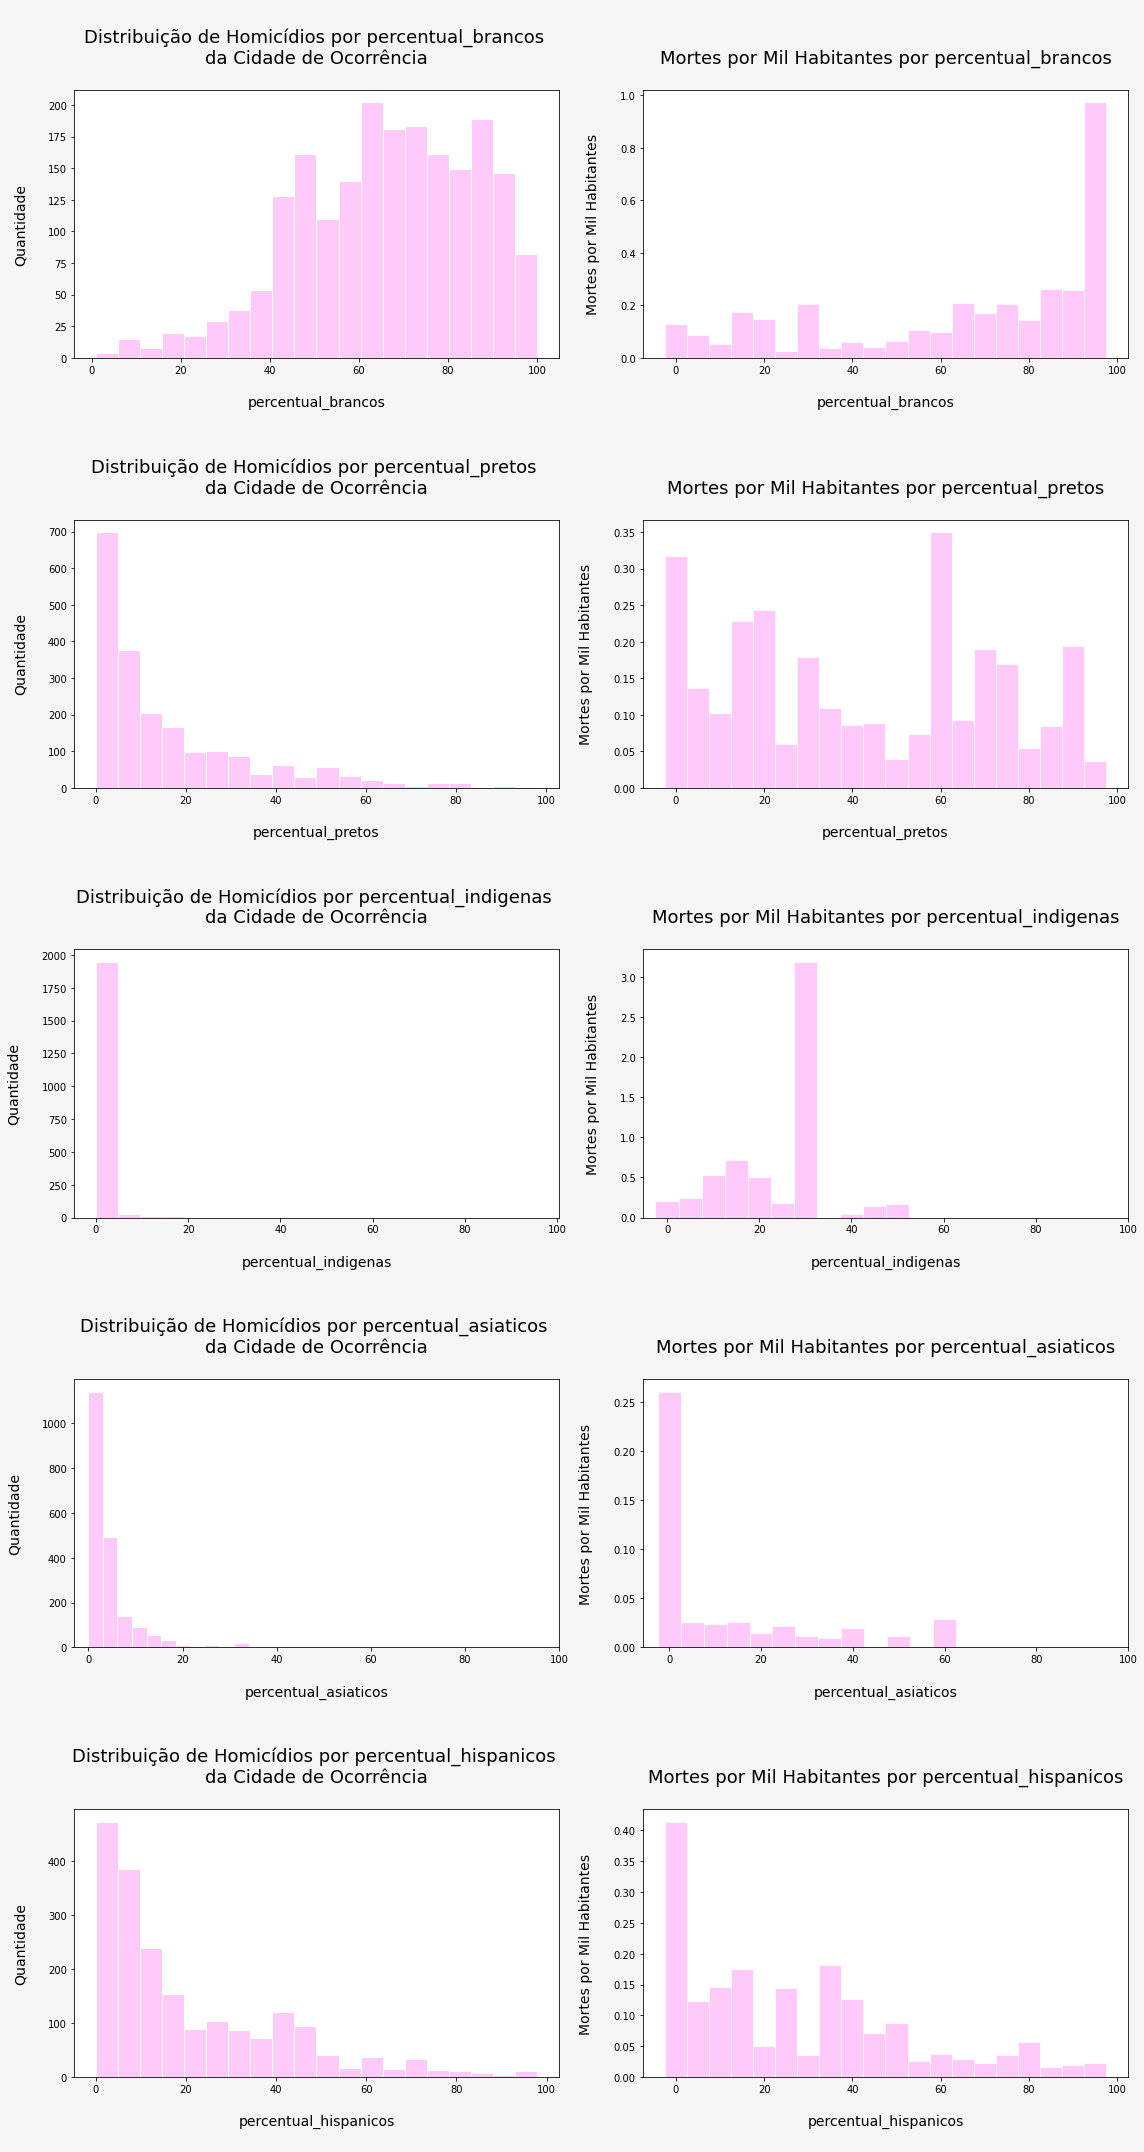

In [0]:
fato_homicidios_cidades = spark.table("gold.fato_homicidios_cidades").toPandas()
fato_homicidios_mil_habitantes = spark.table("gold.fato_homicidios_mil_habitantes").toPandas()

num_rows = len(colunas)
figura, eixos = plt.subplots(nrows=num_rows, ncols=2, figsize=(16, num_rows * 6))
eixos = eixos.flatten()

bins = np.arange(0, 101, 5)

for i, coluna in enumerate(colunas):
    sns.histplot(
        fato_homicidios_cidades[coluna],
        bins=20,
        color="#ffb2f9",
        edgecolor="#FFFFFF",
        alpha=0.7,
        ax=eixos[i * 2]
    )
    eixos[i * 2].set_xlabel(f"\n{coluna}\n", fontsize=14)
    eixos[i * 2].set_ylabel("Quantidade\n", fontsize=14)
    eixos[i * 2].set_title(f"\nDistribuição de Homicídios por {coluna} \nda Cidade de Ocorrência\n", fontsize=18)
    eixos[i * 2].set_xticks(np.arange(0, 101, 20))
    eixos[i * 2].set_xticklabels(np.arange(0, 101, 20))

    fato_homicidios_mil_habitantes["bins"] = pd.cut(
        fato_homicidios_mil_habitantes[coluna], 
        bins=bins, 
        labels=bins[:-1], 
        include_lowest=True,
    )

    grouped = fato_homicidios_mil_habitantes.groupby("bins", observed=False)["mortes_mil_habitantes"].mean().reset_index()
    grouped["bins"] = grouped["bins"].astype(int)

    eixos[i * 2 + 1].bar(grouped["bins"], grouped["mortes_mil_habitantes"], color="#ffb2f9", edgecolor="#FFFFFF", width=5, alpha=0.7)

    eixos[i * 2 + 1].set_xticks(np.arange(0, 101, 20))
    eixos[i * 2 + 1].set_xticklabels(np.arange(0, 101, 20))

    eixos[i * 2 + 1].set_xlabel(f"\n{coluna}\n", fontsize=14)
    eixos[i * 2 + 1].set_ylabel("Mortes por Mil Habitantes\n", fontsize=14)
    eixos[i * 2 + 1].set_title(f"\nMortes por Mil Habitantes por {coluna}\n", fontsize=18)

plt.tight_layout()
figura.set_facecolor("whitesmoke")
plt.show()


In [0]:
# sns.histplot(
#     silver_dimensao_percentual_racas["percentual_brancos"],
#     bins=20,
#     color="#ffb2f9",
#     edgecolor="#FFFFFF",
#     kde=True,
# )

In [0]:
# groupby = gold.groupby("percentual_pretos")["id"].count().reset_index(name="Quantidade").sort_values(by="percentual_pretos")

# #agrupar resultados duplicados pela média entre eles

# silver_dimensao_percentual_racas = silver_dimensao_percentual_racas.groupby(["cidade"], dropna=False)[colunas].mean(numeric_only=True).reset_index()

# num_rows = len(colunas)
# figura, eixos = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, num_rows * 3))
# eixos = eixos.flatten()

# for i, coluna in enumerate(colunas):
#     sns.histplot(
#         gold[coluna],
#         bins=20,
#         color="#ffb2f9",
#         edgecolor="#FFFFFF",
#         kde=True,
#         ax=eixos[i * 2]
#     )
#     eixos[i * 2].set_xlabel(f"\n{coluna}\n")
#     eixos[i * 2].set_ylabel("Quantidade\n")
#     eixos[i * 2].set_title(f"Distribuição de Homicídios por {coluna} \nda Cidade de Ocorrência\n")

#     sns.histplot(
#         silver_dimensao_percentual_racas[coluna],
#         bins=20,
#         color="#ffb2f9",
#         edgecolor="#FFFFFF",
#         kde=True,
#         ax=eixos[i * 2 + 1]  # Organizando corretamente a estrutura em pares
#     )
#     eixos[i * 2 + 1].set_xlabel(f"\n{coluna}\n")
#     eixos[i * 2 + 1].set_ylabel("Quantidade\n")
#     eixos[i * 2 + 1].set_title(f"Distribuição de Cidades por {coluna}\n")

# # Ajustar fundo da imagem uma única vez
# figura.set_facecolor("whitesmoke")

# # Melhorar layout e remover possíveis eixos vazios
# plt.tight_layout()
# plt.show()